In [17]:
# ====================================================================
# STEP 1: Import Libraries & Mount Drive
# ====================================================================
# This cell handles the initial setup.

# Libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# LightGBM for our regression model
import lightgbm as lgb

# Scikit-learn for splitting data and evaluating the model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Libraries for plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Joblib for saving our trained model
import joblib

# Mount Google Drive to access our dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# ====================================================================
# STEP 2: Load the Final Cleaned Dataset
# ====================================================================

file_path = '/content/drive/MyDrive/WattVision_Preprocessing//data/outputs/final_cleaned_smart_6hour.csv'

# Load the dataset
df = pd.read_csv(file_path)

print("✅ Dataset loaded successfully!")
print(f"   - Shape of the dataset: {df.shape}")
print("\n--- First 5 rows of the dataset ---")
display(df.head())

✅ Dataset loaded successfully!
   - Shape of the dataset: (4441001, 29)

--- First 5 rows of the dataset ---


,BRANCH,DEPOT,SUB_TYPE,E_BILLING,EXPORT,TOTAL_IMPORT (kWh),TOTAL_EXPORT (kWh),TOTAL_IMPORT - PV1 (kWh),TOTAL_EXPORT - PV1 (kWh),TR1_TOTAL_IMPORT (kWh),...,TR2_TOTAL_EXPORT - PV1 (kWh),TR3_TOTAL_EXPORT - PV1 (kWh),PHASE_A_CURRENT (A),PHASE_A_VOLTAGE (V),FREQUENCY (Hz),year,month,hour,NET_IMPORT_kWh,EXPORT_IMPORT_RATIO
0,MORATUWA,MORATUWA NORTH C.S.C,Anteleco - DLMS SinglePhase,0,0,-0.275839,-0.250803,-0.271832,-0.191859,-0.221575,...,-0.004556,-0.004703,-0.398213,0.952359,0.844265,2023.0,1.0,0.0,870.3110,-0.022618
1,MORATUWA,MORATUWA SOUTH C.S.C,Anteleco - DLMS SinglePhase,0,0,-0.256524,-0.250803,-0.252341,-0.191859,-0.216673,...,-0.004556,-0.004703,-0.153840,0.011102,-0.976584,2023.0,1.0,18.0,1092.5241,-0.022618
2,MORATUWA,MORATUWA NORTH C.S.C,Anteleco - DLMS SinglePhase,0,0,-0.239640,-0.250803,-0.235216,-0.191859,-0.178338,...,-0.004556,-0.004703,1.443809,-0.125825,-1.482376,2023.0,1.0,18.0,1286.7710,-0.022618
3,MORATUWA,MORATUWA SOUTH C.S.C,Anteleco - IEC SinglePhase,0,0,-0.306565,-0.250803,-0.303212,-0.191859,-0.244767,...,-0.004556,-0.004703,-0.210246,-2.812685,-0.470793,2023.0,1.0,18.0,516.8100,-0.022618
4,MORATUWA,MORATUWA NORTH C.S.C,Anteleco - IEC 3Phase,1,1,0.922318,1.662764,0.945870,1.289459,0.328657,...,-0.004556,-0.004703,2.594787,0.055581,-0.875426,2023.0,1.0,18.0,-1182.5700,-0.022022


In [19]:
# ====================================================================
# STEP 3: Verify that the Target Variable is NOT Scaled
# ====================================================================

print("--- Descriptive Statistics for 'NET_IMPORT_kWh' ---")
display(df['NET_IMPORT_kWh'].describe())

print("\nObservation: The mean is not ~0 and the min/max range is wide, confirming it is not scaled.")

--- Descriptive Statistics for 'NET_IMPORT_kWh' ---


,NET_IMPORT_kWh
count,4.441001e+06
mean,1.968055e+03
std,1.338601e+04
min,-2.176603e+05
25%,7.116700e+02
50%,1.809804e+03
75%,3.143883e+03
max,4.603319e+05



Observation: The mean is not ~0 and the min/max range is wide, confirming it is not scaled.


In [20]:
# ====================================================================
# STEP 4: Data Preparation for LightGBM
# ====================================================================
# Convert object columns to the 'category' data type for optimal performance.

for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')

print("✅ Categorical features converted successfully.")

✅ Categorical features converted successfully.


In [22]:
# ====================================================================
# STEP 5: Define Features (X) and Target (y)
# ====================================================================

# The target variable we want to predict
target_column = 'NET_IMPORT_kWh'

# Columns that are direct components or proxies of the target variable.
# These MUST be removed to prevent data leakage.
all_leakage_columns = [
    'TOTAL_IMPORT (kWh)', 'TOTAL_EXPORT (kWh)', 'TOTAL_IMPORT - PV1 (kWh)',
    'TOTAL_EXPORT - PV1 (kWh)', 'TR1_TOTAL_IMPORT (kWh)', 'TR2_TOTAL_IMPORT (kWh)',
    'TR3_TOTAL_IMPORT (kWh)', 'TR1_TOTAL_EXPORT (kWh)', 'TR2_TOTAL_EXPORT (kWh)',
    'TR3_TOTAL_EXPORT (kWh)', 'TR1_TOTAL_IMPORT - PV1 (kWh)', 'TR2_TOTAL_IMPORT - PV1 (kWh)',
    'TR3_TOTAL_IMPORT - PV1 (kWh)', 'TR1_TOTAL_EXPORT - PV1 (kWh)', 'TR2_TOTAL_EXPORT - PV1 (kWh)',
    'TR3_TOTAL_EXPORT - PV1 (kWh)', 'EXPORT_IMPORT_RATIO'
]

# Create the features DataFrame (X) by dropping the target and ALL leakage columns
X = df.drop(columns=[target_column] + all_leakage_columns)

# Create the target Series (y)
y = df[target_column]

print("✅ Features (X) and Target (y) have been defined.")
print(f"   - Shape of Features (X): {X.shape}")
print(f"   - Shape of Target (y): {y.shape}")

✅ Features (X) and Target (y) have been defined.
   - Shape of Features (X): (4441001, 11)
   - Shape of Target (y): (4441001,)


In [23]:
# ====================================================================
# STEP 6: Split Data into Training and Testing Sets
# ====================================================================

# Split the data with an 80% training set and 20% testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Data has been split into training and testing sets:")
print(f"   - Training set size: {X_train.shape[0]} rows")
print(f"   - Testing set size: {X_test.shape[0]} rows")

✅ Data has been split into training and testing sets:
   - Training set size: 3552800 rows
   - Testing set size: 888201 rows


In [24]:
# ====================================================================
# STEP 7: Train and Evaluate the Baseline Model
# ====================================================================

# Initialize and train the model with default parameters
baseline_model = lgb.LGBMRegressor(random_state=42)
baseline_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_baseline = baseline_model.predict(X_test)
r2_baseline = r2_score(y_test, y_pred_baseline)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))


print("\n--- Baseline Model Evaluation ---")
print(f"R-squared (R²): {r2_baseline:.4f}")
print(f"Mean Absolute Error (MAE): {mae_baseline:.2f} kWh")
print(f"Root Mean Squared Error (RMSE): {rmse_baseline:.2f} kWh")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.070564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 3552800, number of used features: 11
[LightGBM] [Info] Start training from score 1963.758201

--- Baseline Model Evaluation ---
R-squared (R²): 0.7940
Mean Absolute Error (MAE): 2475.39 kWh
Root Mean Squared Error (RMSE): 6088.57 kWh


In [25]:
# ====================================================================
# STEP 8: Hyperparameter Tuning to Create Model Varieties
# ====================================================================
print("--- Training Model Varieties to Find Best Parameters ---")

# Define different 'n_estimators' values to try
estimator_options = [100, 200, 300]
results = []

for n in estimator_options:
    print(f"\nTraining with n_estimators = {n}...")
    model_variety = lgb.LGBMRegressor(n_estimators=n, random_state=42)
    model_variety.fit(X_train, y_train)
    y_pred_variety = model_variety.predict(X_test)
    r2_variety = r2_score(y_test, y_pred_variety)
    results.append({'n_estimators': n, 'R-squared': r2_variety})
    print(f"Result: R-squared = {r2_variety:.4f}")

--- Training Model Varieties to Find Best Parameters ---

Training with n_estimators = 100...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.293631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 3552800, number of used features: 11
[LightGBM] [Info] Start training from score 1963.758201
Result: R-squared = 0.7940

Training with n_estimators = 200...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.299127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 689
[LightGBM] [I

In [26]:
# ====================================================================
# STEP 9 : Compare Model Varieties and Select the Best One
# ====================================================================

results_df = pd.DataFrame(results)

print("\n--- Model Comparison Table ---")
display(results_df)

# Find the best model based on the highest R-squared value
best_model_stats = results_df.loc[results_df['R-squared'].idxmax()]

# --- CONCLUSION ---
# The print statement has been updated to only show the R-squared score, which matches the data we have.
print(f"\n--- Conclusion ---")
print(f"✅ The best model variety was with n_estimators = {int(best_model_stats['n_estimators'])}.")
print(f"   This model achieved the highest R-squared of {best_model_stats['R-squared']:.4f}.")

# Define the final model based on tuning
best_n_estimators = int(best_model_stats['n_estimators'])
final_model = lgb.LGBMRegressor(n_estimators=best_n_estimators, random_state=42)

# Retrain the final model on the full training data
print("\nRetraining the final best model...")
final_model.fit(X_train, y_train)
print("✅ Final model is ready.")


--- Model Comparison Table ---


,n_estimators,R-squared
0,100,0.793993
1,200,0.830725
2,300,0.844806



--- Conclusion ---
✅ The best model variety was with n_estimators = 300.
   This model achieved the highest R-squared of 0.8448.

Retraining the final best model...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.298082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 3552800, number of used features: 11
[LightGBM] [Info] Start training from score 1963.758201
✅ Final model is ready.



--- Final Model Performance ---
R-squared (R²): 0.8448
Mean Absolute Error (MAE): 2231.32 kWh
Root Mean Squared Error (RMSE): 5284.59 kWh

--- Feature Importance ---


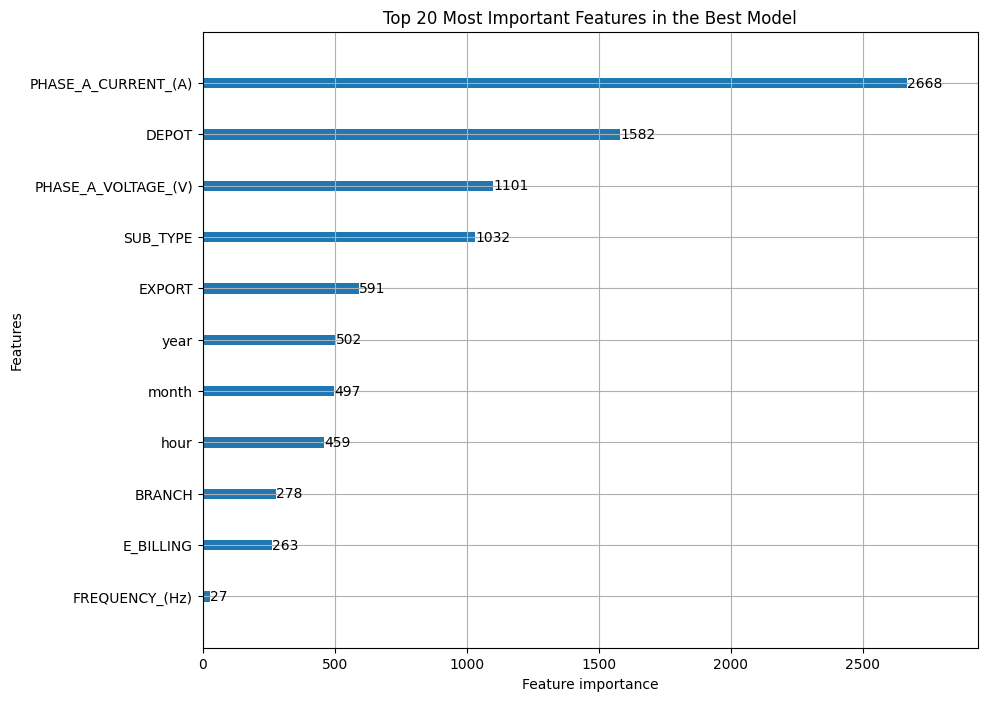


--- Prediction Accuracy Visualization ---


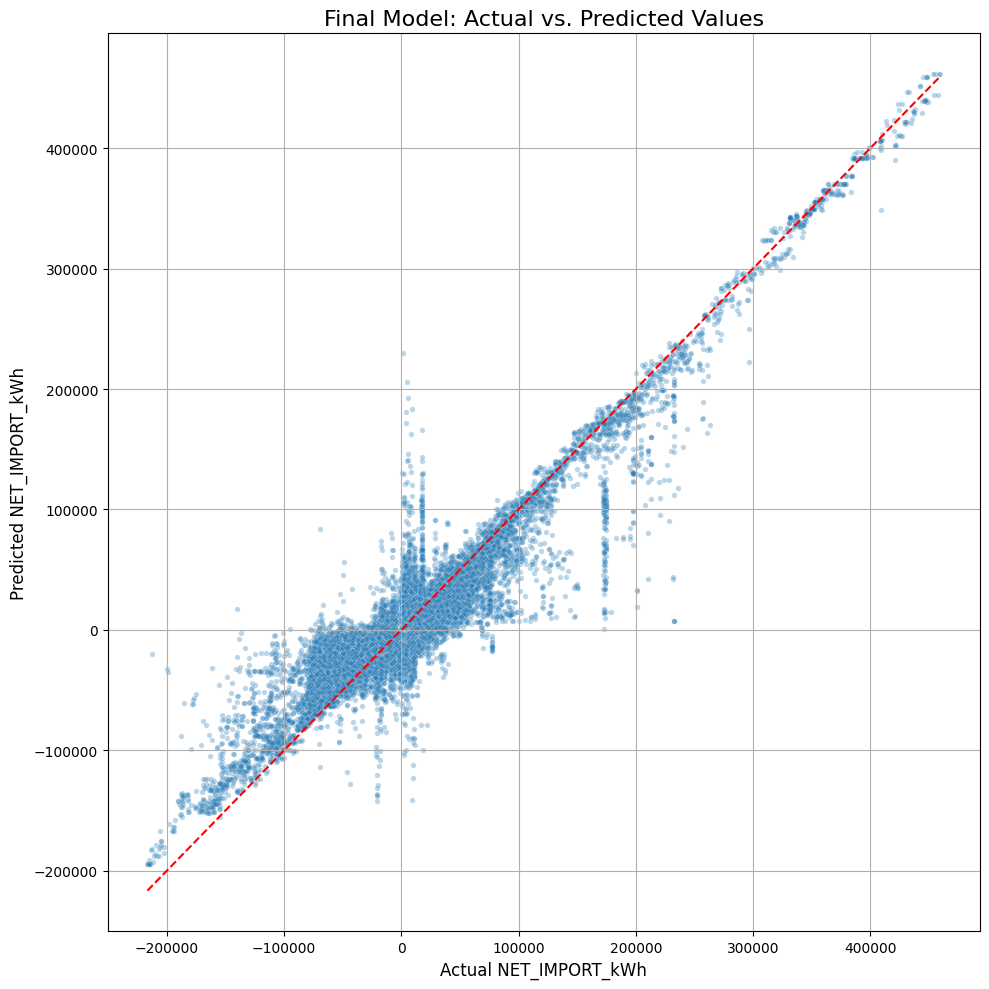

In [27]:
# ====================================================================
# STEP 10: Final Evaluation and Visualization of Best Model
# ====================================================================

# Make final predictions and calculate metrics
y_pred_final = final_model.predict(X_test)
mae_final = mean_absolute_error(y_test, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
r2_final = r2_score(y_test, y_pred_final)

print("\n--- Final Model Performance ---")
print(f"R-squared (R²): {r2_final:.4f}")
print(f"Mean Absolute Error (MAE): {mae_final:.2f} kWh")
print(f"Root Mean Squared Error (RMSE): {rmse_final:.2f} kWh")

# --- Feature Importance Plot ---
print("\n--- Feature Importance ---")
lgb.plot_importance(final_model, max_num_features=20, figsize=(10, 8))
plt.title("Top 20 Most Important Features in the Best Model")
plt.show()

# --- Actual vs. Predicted Scatter Plot ---
print("\n--- Prediction Accuracy Visualization ---")
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test, y=y_pred_final, alpha=0.3, s=15)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual NET_IMPORT_kWh', fontsize=12)
plt.ylabel('Predicted NET_IMPORT_kWh', fontsize=12)
plt.title('Final Model: Actual vs. Predicted Values', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
# ====================================================================
# STEP 11: Simplified Accuracy Check
# ====================================================================

# Create a DataFrame for a side-by-side comparison
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_final})
comparison_df['Absolute Error (kWh)'] = abs(comparison_df['Actual'] - comparison_df['Predicted'])

# Display a random sample of 15 predictions
print("--- Comparison of Actual vs. Predicted Values (Random Sample) ---")
display(comparison_df.sample(15, random_state=42))

# Display the final, easy-to-understand average error
print("\n--- Average Error Summary ---")
print(f"On average, the model's prediction is off by only {mae_final:.2f} kWh.")

--- Comparison of Actual vs. Predicted Values (Random Sample) ---


,Actual,Predicted,Absolute Error (kWh)
4355276,2600.188,3735.417950,1135.229950
4042011,2615.681,3312.921304,697.240304
829450,1277.458,2161.734217,884.276217
4332582,13143.215,3666.024955,9477.190045
260751,-1318.640,-2001.121818,682.481818
2110558,-6931.983,-3749.074131,3182.908869
2111336,-14798.899,-1549.611767,13249.287233
3453321,5126.021,3377.375932,1748.645068
3304373,1376.650,2183.270251,806.620251
511009,-5045.745,-2771.415072,2274.329928



--- Average Error Summary ---
On average, the model's prediction is off by only 2231.32 kWh.
